# UCLA Scandinavian DH Seminar, November 2017

## Classification demo of melodrama in Danish literature

Notebook to perform text classification for seminar hackathon. Not production code, though it all works. Exists mostly to document process.

Steps:

* Import metadata with gold standard classes from Google sheet
* Calculate TF-IDF features and text similarities
* Explore the training corpus a bit with unsupervised methods
* Evaluate classification performance with cross-validated measures in training set
* Explore features of the trained model

Initial work by Matthew Wilkens, November 2017. Cleanup and sharing late November/early December 2017. Draws on work by [Stefan Sinclair](https://github.com/htrc/ACS-TT/blob/master/tools/notebooks/ClassifyingPhilosophicalText.ipynb) and by [Thomas Buhrmann](https://buhrmann.github.io/tfidf-analysis.html).

In [1]:
import pandas as pd
import nltk
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_footer
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_quoting
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from IPython.display import display
import random

%matplotlib inline

corpus_name  = 'ADL'
figDir       = 'figures'
resultsDir   = 'results'
dataDir      = os.path.join('..', '..', corpus_name)
metadataFile = os.path.join(dataDir, 'metadata', 'metadata_adl.csv')
corpusDir    = os.path.join(dataDir, 'plain')

sns.set()
sns.set_context('notebook')
plt.rc('figure', figsize=(12, 8))
pd.options.mode.chained_assignment = None # Disable warning re: setting value on slice of dataframe

In [62]:
column_names = ['file_id', 'author', 'title', 'volume', 'birth', 'death', 'melodrama']

gsheet_url = 'https://docs.google.com/spreadsheets/d/1GVQizIQmNgkDQB6a5771hrM9UMILBk6i9GrObM_Dn5I/export?format=csv'

true_values = ['True', 'TRUE', 'Yes']
false_values = ['False', 'FALSE', 'No']
metadata = pd.read_csv(gsheet_url, header=0, names=column_names, true_values=true_values, false_values=false_values)
metadata.head()

,file_id,author,title,volume,birth,death,melodrama
0,hcaeventyr02val_workid82056,Hans Christian Andersen,Hyldemoer. (eventyrspil),Eventyr II,1805.0,1875.0,True
1,hertz04val_workid64372,Henrik Hertz,Svanehammen (romantisk pastoral),Dramatiske Værker,1798.0,1870.0,True
2,hertz03val_workid53734,Henrik Hertz,Sparekassen (familiekomedie),Dramatiske Værker,1798.0,1870.0,True
3,hostrup01_workid75661,Jens Christian Hostrup,En spurv i tranedans (komedie),KOMEDIER OG DIGTE,1818.0,1892.0,True
4,hostrup01_workid119933,Jens Christian Hostrup,Intrigerne (sangspil),KOMEDIER OG DIGTE,1818.0,1892.0,True


In [63]:
md = metadata.loc[~metadata.melodrama.isnull()]
md.describe()

,birth,death
count,25.000000,25.000000
mean,1793.320000,1863.840000
std,11.999028,12.995769
min,1779.000000,1850.000000
25%,1791.000000,1860.000000
50%,1791.000000,1860.000000
75%,1798.000000,1870.000000
max,1818.000000,1892.000000


In [65]:
print(md.melodrama.value_counts())

True     16
False     9
Name: melodrama, dtype: int64


Authors in corpus: 5
Volumes in corpus: 12
Texts in corpus: 25
Texts by author birth date ...


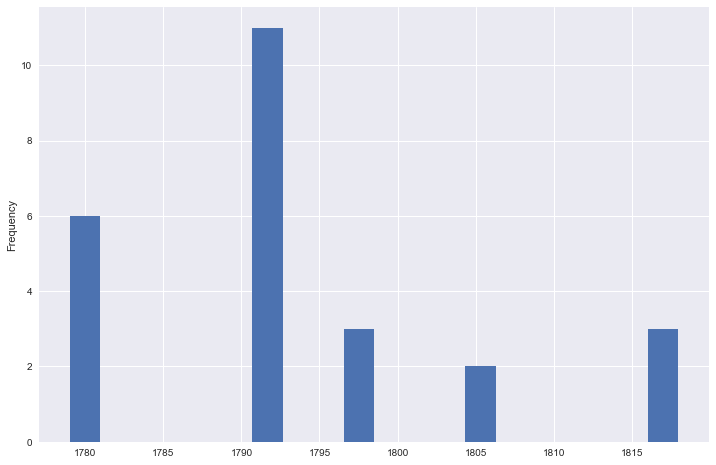

In [66]:
print("Authors in corpus:", md.author.nunique())
print("Volumes in corpus:", md.volume.nunique())
print("Texts in corpus:", md.volume.count())
print("Texts by author birth date ...")
fig = md.birth.plot.hist(bins=20)

In [67]:
#Read in full texts from training set
filenames = [file_id+'.txt' for file_id in md.file_id]
corpus = PlaintextCorpusReader(corpusDir, filenames)

In [68]:
# Engineer some features
# Tf-idf components
file_labels = []
for fn in filenames:
    if md[md.file_id == fn.strip('.txt')].melodrama.all():
        file_labels.append('m-'+fn.strip('.txt'))
    else:
        file_labels.append('o-'+fn.strip('.txt'))
texts = [corpus.raw(fileid) for fileid in filenames]
vectorizer = TfidfVectorizer(use_idf=True,
                             min_df = 2, max_df = 0.5,
                             max_features=5000)
documentTermMatrix = vectorizer.fit_transform(texts)
reducer = TruncatedSVD(n_components=50)
tfidf_features = documentTermMatrix
tfidf_features.shape # number of texts x number of features

(25, 5000)

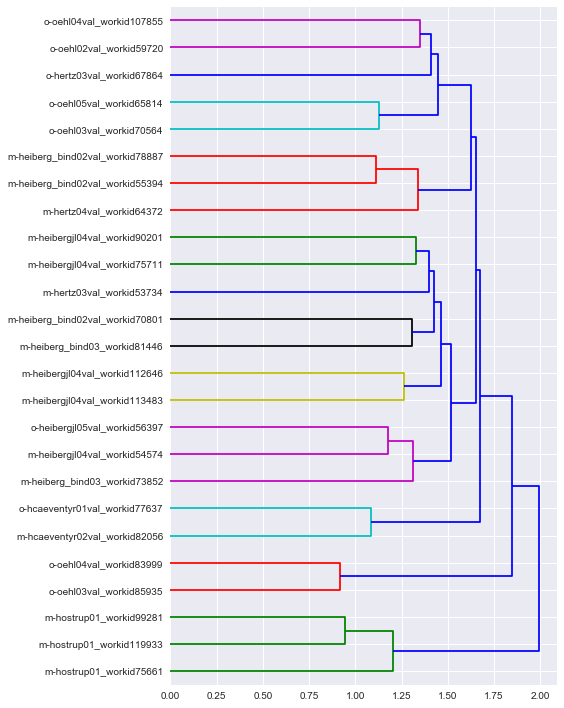

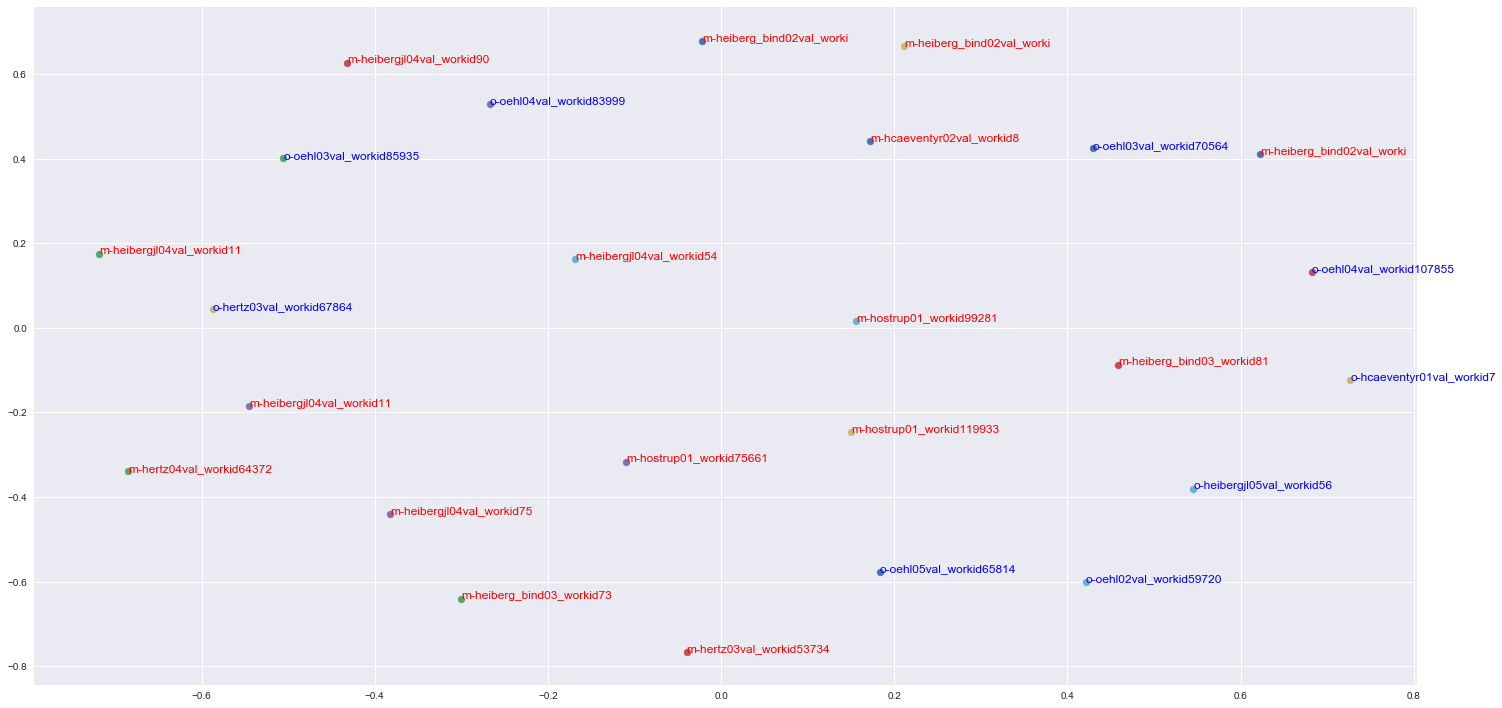

In [69]:
# Compute text similarity and plot with scatter and denrogram
distances = 1 - cosine_similarity(tfidf_features)
mds = MDS(dissimilarity="precomputed", random_state=1)
positions = mds.fit_transform(distances)

# Plot dendrogram
linkage_matrix = ward(distances)
plt.figure(figsize=(8,10))
dendrogram(linkage_matrix, labels=file_labels, orientation="right")
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'ward.png'), dpi=300)
plt.show()

# Plot scatter
xvalues = positions[:, 0] 
yvalues = positions[: ,1] 
plt.figure(figsize=(20,10))
for x, y, name in zip(xvalues, yvalues, file_labels):
    plt.scatter(x, y)
    plt.text(x, y, name.replace(".txt", "")[:25], 
             color='red' if 'm-' in name else 'blue')
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'scatter.png'), dpi=300)
plt.show()

Unsurprisingly, not much structure here with 25 texts in 5,000-dimensional space.

In [70]:
# Imports for classification
from collections import defaultdict
from pandas import DataFrame
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

In [71]:
def benchmark_svms(labelled_texts, runs, vectorizer, categories):
    '''Compare classifiers by averaging accuracy over multiple 50/50 splits of corpus.
       Takes a list of (label, raw_text) tuples, number of runs, NLTK vectorizer, and
          list of (indicator, category name) tuples.
       Prints accuracies and plots same.
       Returns results dataframe.'''
    results = defaultdict(list)
    split = int(len(labelled_texts)/2)
    for i in range(0, runs):
        random.shuffle(labelled_texts)
        train_set, test_set = labelled_texts[split:], labelled_texts[:split]
        train_set_categories = [categories[0][1] if categories[0][0] in category else categories[1][1] for category, text in train_set]
        test_set_categories  = [categories[0][1] if categories[0][0] in category else categories[1][1] for category, text in test_set]
        X_train = vectorizer.fit_transform([text for category, text in train_set])
        X_test = vectorizer.transform([text for category, text in test_set])

        for clf, name in (
                (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
                (Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
                (PassiveAggressiveClassifier(max_iter=50, tol=1e-3), "Passive-Aggressive"),
                (KNeighborsClassifier(n_neighbors=10), "kNN"),
                (LinearSVC(), "LinearSVC"),
                (LinearSVC(loss='squared_hinge', penalty="l2", dual=False, tol=1e-3), "LinearSVC L2"),
                (LinearSVC(loss='squared_hinge', penalty="l1", dual=False, tol=1e-3), "LinearSVC L1"),
                (SGDClassifier(alpha=.0001, max_iter=50, tol=1e-4, penalty="l2"), "SGD L2"),
                (SGDClassifier(alpha=.0001, max_iter=50, tol=1e-4, penalty="l1"), "SGD L1"),
                (SGDClassifier(alpha=.0001, max_iter=50, tol=1e-4, penalty="elasticnet"), "SGD elasticnet"),
                (NearestCentroid(), "NearestCentroid"),
                (MultinomialNB(alpha=.01), "Naïve Bayes Multinomial"),
                (BernoulliNB(alpha=.01), "Naïve Bayes Bernoulli")):
            clf.fit(X_train, train_set_categories)
            results[name].append(clf.score(X_test, test_set_categories))
    orderedresults = [(name, values) for name, values in results.items()] 
    results_df = DataFrame([values for name,values in orderedresults], 
                           index=[name for name,values in orderedresults])
    summary = DataFrame(results_df.mean(axis=1), columns=['acc'])
    summary['std'] = results_df.std(axis=1)
    print("Ordered averages:")
    print(summary.sort_values('acc', ascending=False))
    results_df.transpose().plot(figsize=(20, 10))
    plt.savefig(os.path.join(figDir, 'classifiers.png'), dpi=300)
    return results_df

Ordered averages:
                              acc       std
Naïve Bayes Bernoulli    0.806667  0.108379
Naïve Bayes Multinomial  0.800000  0.069416
SGD elasticnet           0.791667  0.077610
SGD L1                   0.791667  0.091054
SGD L2                   0.790000  0.105463
Passive-Aggressive       0.785000  0.084331
Perceptron               0.780000  0.113888
NearestCentroid          0.775000  0.101365
LinearSVC                0.735000  0.130073
LinearSVC L2             0.735000  0.130073
Ridge Classifier         0.705000  0.146007
kNN                      0.650000  0.095238
LinearSVC L1             0.631667  0.103906
CPU times: user 16.8 s, sys: 149 ms, total: 17 s
Wall time: 17 s


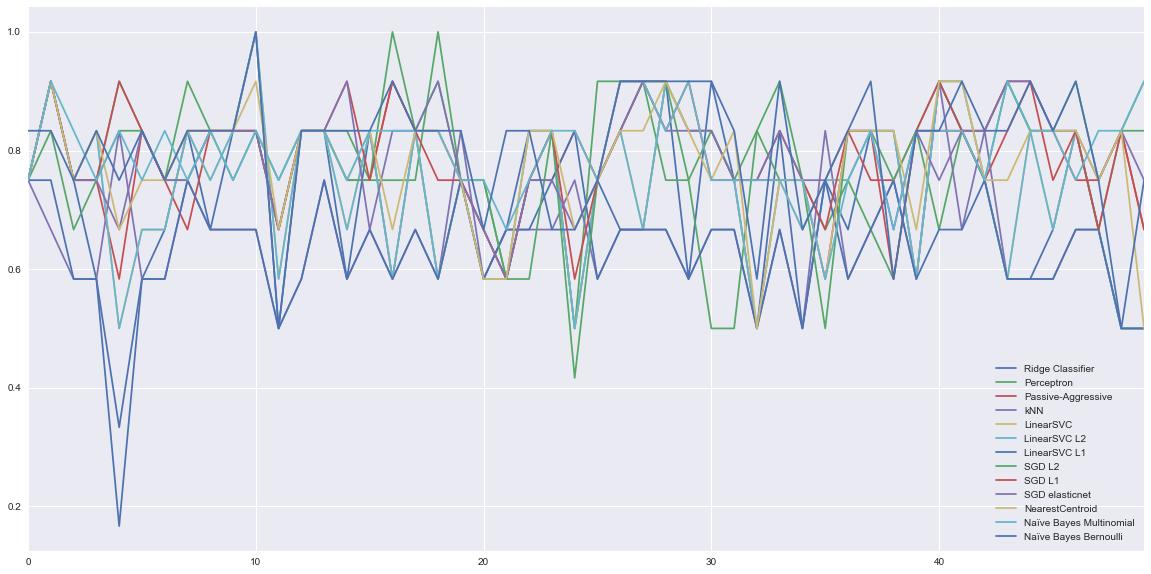

In [72]:
labelled_texts = [(fl, corpus.raw(fl[2:]+'.txt')) for fl in file_labels]
class_labels = [('m-', 'melodrama'), ('o-', 'other')]
%time results = benchmark_svms(labelled_texts, 50, vectorizer, class_labels)

## Predict unseen data

Use a classifier trained on the full toy corpus to predict unseen texts.

In [77]:
# Train classifier
X_train = vectorizer.fit_transform([corpus.raw(fileid) for fileid in corpus.fileids()])
train_set_categories = ['other' if 'o-' in category else 'melodrama' for category, text in labelled_texts]
clf = MultinomialNB(alpha=.01)
clf.fit(X_train, train_set_categories)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [78]:
# Read in test corpus, vectorize, and predict classes
test_dir = 'texts/'
test_corpus = nltk.corpus.reader.plaintext.PlaintextCorpusReader(test_dir, ".*\.txt")
test_fileids = [fileid for fileid in test_corpus.fileids()]
test_categories = ["other" if "o-" in fileid else "melodrama" for fileid in test_fileids]

X_test = vectorizer.transform([test_corpus.raw(fileid) for fileid in test_fileids])
pred = clf.predict(X_test)

In [79]:
for i in range(len(test_fileids)):
    print(test_fileids[i].strip('.txt')) 
    if test_categories[i] == pred[i]:
        print('\t', test_categories[i])
    else:
        print('  ### ERROR ###')
        print('  Actual:   ', test_categories[i])
        print('  Predicted:', pred[i])

m-heiberg_bind02val_workid55394
  ### ERROR ###
  Actual:    melodrama
  Predicted: other
o-oehl04val_workid107855
	 other


In [80]:
md[md.file_id=='heiberg_bind02val_workid55394']

,file_id,author,title,volume,birth,death,melodrama
6,heiberg_bind02val_workid55394,Johan Ludvig Heiberg,Elverhøi. skuespil i 5 acter,Poetiske skrifter II,1791.0,1860.0,True


In [81]:
prob = clf.predict_proba(X_test)
for i in range(len(test_fileids)):
    print(test_fileids[i].strip('.txt'))
    print('   Actual:   ', test_categories[i])
    print('   Predicted %:\n\tmelodrama', round(prob[i][0]*100, 2), '\tother', round(prob[i][1]*100, 2))

m-heiberg_bind02val_workid55394
   Actual:    melodrama
   Predicted %:
	melodrama 0.0 	other 100.0
o-oehl04val_workid107855
   Actual:    other
   Predicted %:
	melodrama 0.34 	other 99.66


Doesn't work well on these two(!) test texts. Would want to explore in more detail if continuing.

## Feature importance

Cribbed from https://buhrmann.github.io/tfidf-analysis.html

In [82]:
features = vectorizer.get_feature_names()

In [83]:
# Helper function to get top features for matrix row
import numpy as np
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [84]:
# Function to get top features in a document
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [85]:
top_feats_in_doc(X_train, features, 0)

,feature,tfidf
0,drengen,0.296350
1,deiligt,0.241121
2,hyldetræet,0.224971
3,nyboder,0.224971
4,nikkede,0.224971
5,træet,0.176093
6,moderen,0.164639
7,stode,0.150878
8,fløi,0.146744
9,mgl,0.134982


In [86]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.01, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [87]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.01, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        #ids = np.where(y==label)
        ix = np.isin(train_set_categories, label)
        ids = np.where(ix)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [88]:
labels = np.unique(train_set_categories)
print(labels)

['melodrama' 'other']


In [89]:
dfs = top_feats_by_class(X_train, train_set_categories, features)

In [90]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf[::-1], align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature[::-1])
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.savefig(os.path.join(figDir, 'topwords.png'), dpi=300)
    plt.show()

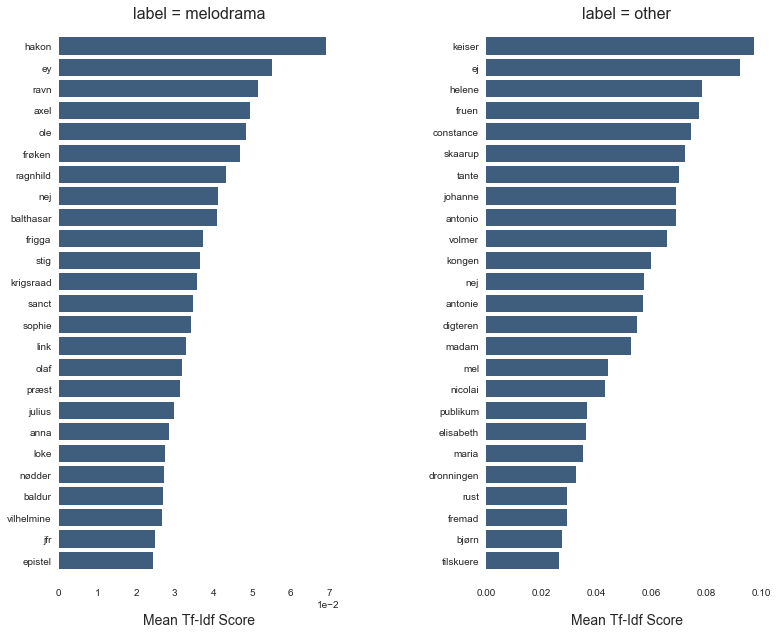

In [91]:
plot_tfidf_classfeats_h(dfs)